<a href="https://colab.research.google.com/github/satishchaudhary382/RFM/blob/master/supertrend-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import pandas_ta as ta
import pandas_datareader as pdr

In [222]:
df = pd.read_csv("/content/shivm.csv")
df.set_index(['Date'],inplace = True)

In [223]:
df

,Open,High,Low,Close,Volume
Date,,,,,
7/30/2019,603,605,597,597,16437
7/31/2019,600,617,597,602,21180
8/1/2019,602,610,598,598,11897
8/4/2019,600,600,590,590,13070
8/5/2019,590,600,580,583,27388
...,...,...,...,...,...
7/22/2020,615,626,606,608,22654
7/23/2020,608,619,601,616,28785
7/26/2020,620,628,608,621,32356


In [224]:
raw = df.copy()
raw['ADX'] = ta.adx(raw.High, raw.Low, raw.Close)['ADX_14']
raw['DMP'] = ta.adx(raw.High, raw.Low, raw.Close)['DMP_14']
raw['DMN'] = ta.adx(raw.High, raw.Low, raw.Close)['DMN_14']

In [225]:
w = []
for i in range(len(df)):
  t = raw[:i+1]
  
  if (t['ADX'].values[i]>0) and (t['ADX'].values[i]<=20):
    w.append(ta.supertrend(t.High, t.Low, t.Close, 7, 3.0)['SUPERT_7_3.0'].values[-1])
  elif (t['ADX'].values[i]>20 and (t['ADX'].values[i]<=40)):
    w.append(ta.supertrend(t.High, t.Low, t.Close, 7,2.0)['SUPERT_7_2.0'].values[-1])
  elif (t['ADX'].values[i]>40 and (t['ADX'].values[i]<=50)):
    w.append(ta.supertrend(t.High, t.Low, t.Close, 7,1.75)['SUPERT_7_1.75'].values[-1])  
  elif (t['ADX'].values[i]>50) and (t['ADX'].values[i]<=100):
    w.append(ta.supertrend(t.High, t.Low, t.Close, 7,1.0)['SUPERT_7_1.0'].values[-1])
  # elif (t['ADX'].values[i]>75) and (t['ADX'].values[i]<=100):
  #   w.append(ta.supertrend(t.high, t.low, t.close, 14, 1.0)['SUPERT_14_1.0'].values[-1])


In [226]:
data = df.iloc[1:].copy()
data['Supertrend'] = w

In [227]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Supertrend'], dtype='object')

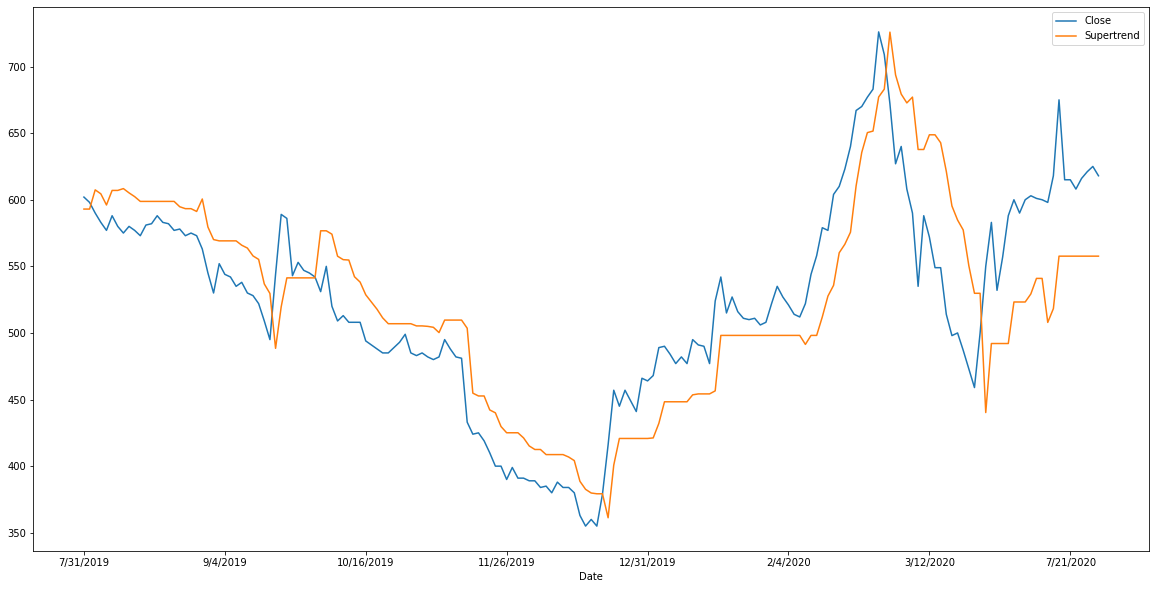

In [228]:
data[['Close','Supertrend']].plot(figsize = (20,10))

In [178]:
# long = (ta.wma(df.Close.shift(-2),30)-ta.wma(df.Close,30)) > 0
long = data.Close>data.Supertrend

In [180]:
trendy = data.ta.trend_return(trend=long, cumulative=True)
trendy.tail() 

,CLTR,TR_LOGRET,CLTR_Trends,CLTR_Trades
date,,,,
7/22/2020,0.100257,-0.011447,1,0
7/23/2020,0.113329,0.013072,1,0
7/26/2020,0.121413,0.008084,1,0
7/27/2020,0.127833,0.006421,1,0
7/28/2020,0.116570,-0.011263,1,0


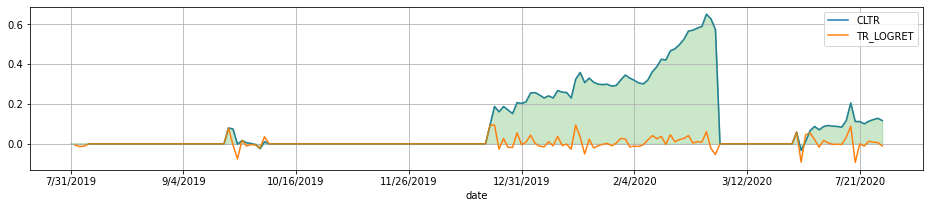

In [181]:
cltr = trendy.iloc[:,0]
tr = trendy.iloc[:,1]

trendy.iloc[:,:2].plot(figsize=(16, 3))
cltr.plot(figsize=(16, 3), kind="area", stacked=False, alpha=0.25, grid=True)

In [182]:
(cltr*20000).cumsum()

date
7/31/2019              NaN
8/1/2019               NaN
8/4/2019               NaN
8/5/2019               NaN
8/6/2019          0.000000
                 ...      
7/22/2020    371839.100112
7/23/2020    374105.673818
7/26/2020    376533.929892
7/27/2020    379090.597323
7/28/2020    381422.000907
Name: CLTR, Length: 181, dtype: float64

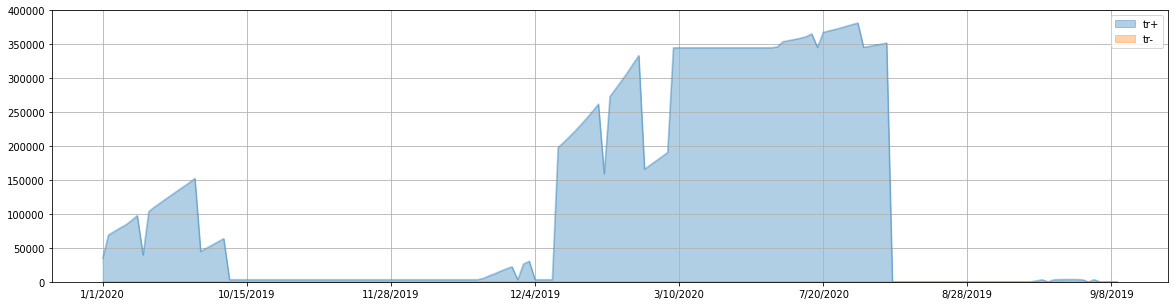

In [183]:
capital = 20000

total_return = (cltr.cumsum() * capital)
positive_return = total_return[total_return > 0]
negative_return = total_return[total_return <= 0]
trdf = pd.DataFrame({"tr+": positive_return, "tr-": negative_return})
trdf.plot(figsize=(20, 5), kind="area", stacked=False, alpha=0.35, grid=True)

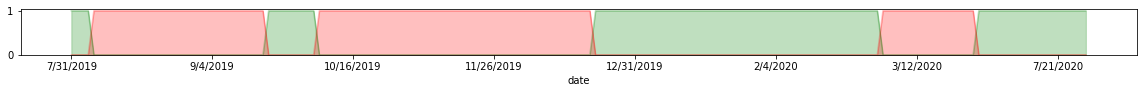

In [184]:
long_trend = (trendy.iloc[:,-2] > 0).astype(int)
short_trend = (1 - long_trend).astype(int)

long_trend.plot(figsize=(20, 0.85), kind="area", color = 'green',stacked=True, alpha=0.25)
short_trend.plot(figsize=(20, 0.85), kind="area", color = 'red', stacked=True,  alpha=0.25)

In [185]:
entries = (trendy.iloc[:,-1] > 0).astype(int) * data.close
entries[entries < 0.0001] = np.nan
entries.name = "Entry"


exits = (trendy.iloc[:,-1] < 0).astype(int) * data.close
exits[exits < 0.0001] = np.nan
exits.name = "Exit"

total_trades = trendy.iloc[:,-1].abs().sum()
print(f"Total Trades: {total_trades}")

all_trades = trendy.iloc[:,-1].copy().fillna(0)
all_trades = all_trades[all_trades != 0]

trades = pd.DataFrame({"Signal": all_trades, entries.name: entries.dropna(), exits.name: exits.dropna()})
trades

Total Trades: 6


,Signal,Entry,Exit
12/19/2019,1,379.0,NaN
3/1/2020,-1,NaN,672.0
6/30/2020,1,550.0,NaN
8/5/2019,-1,NaN,583.0
9/17/2019,1,544.0,NaN
9/30/2019,-1,NaN,550.0


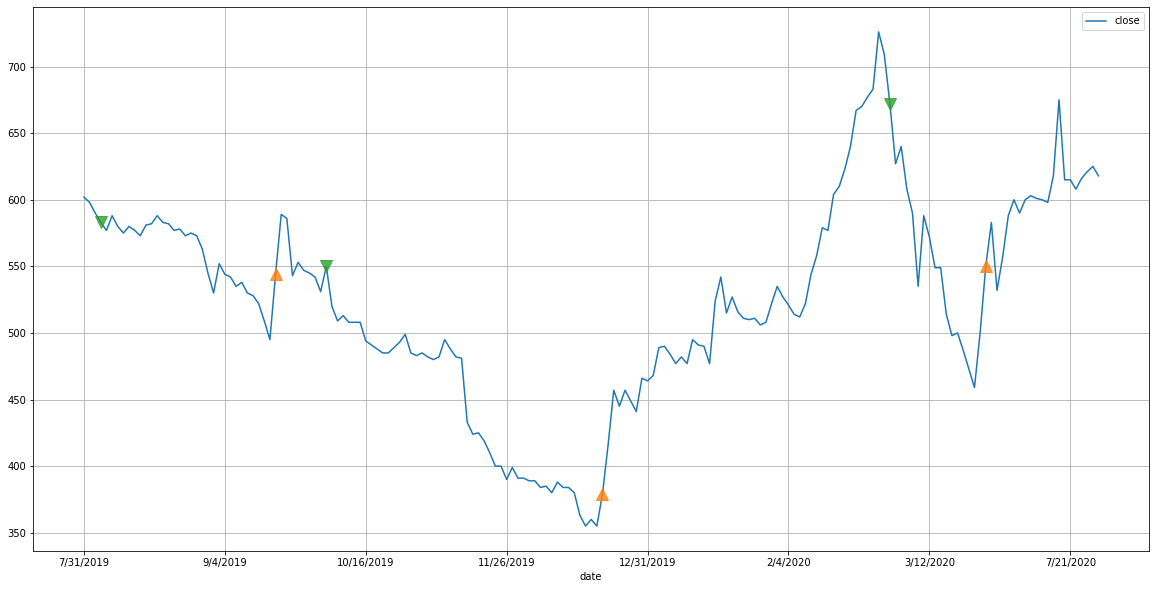

In [186]:

chart = data[["close"]]#, "wma8", "wma21", "wma50"]]
chart.plot(figsize=(20, 10),  grid=True)
entries.plot(figsize=(20, 10), marker="^", markersize=12, alpha=0.8)
exits.plot(figsize=(20, 10),  marker="v", markersize=12, alpha=0.8, grid=True)
# plt.plot(ta.supertrend(df.high,df.low,df.close,21,2.5)[['SUPERTl_21_2.5','SUPERTs_21_2.5']])#plot(figsize=(20,10))

In [118]:
df['c'] = cltr
df.to_csv("a.csv")

In [ ]:
# plt.figure(figsize = (20,10))
# plt.plot(w)
# plt.plot(t.Close[1:].values)
# plt.grid()